In [0]:
#%pip install databricks-mosaic

In [0]:
from pyspark.sql.functions import *
import geopandas as gpd
from shapely import Point, Polygon
import matplotlib.pyplot as plt
from pyspark.sql.types import *

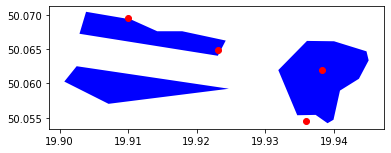

In [0]:

df = spark.read.format("json").load("dbfs:/FileStore/geo/map.geojson")
df = df.select(explode("features").alias("feature"))
df = df.select("feature.geometry.type", "feature.geometry.coordinates")

points = df.filter(col("type") == "Point").toPandas()
points['geometry'] = points.apply(lambda row: Point(row['coordinates']), axis=1)

array_schema = ArrayType(ArrayType(DoubleType()))
polys = df.filter(col("type") == "Polygon").withColumn('coordinates', from_json(col("coordinates")[0], array_schema)).toPandas()
polys['geometry'] = polys.apply(lambda row: Polygon(row['coordinates']), axis=1)

geopoints = gpd.GeoDataFrame(points, geometry='geometry')
geopolys = gpd.GeoDataFrame(polys, geometry='geometry')

ax = geopolys.plot(color='blue')
ax = geopoints.plot(color='red', ax=ax)

plt.show()


In [0]:
display(geopolys.geometry.distance(geopoints.geometry[0]))

0    0.000118
1    0.008043
2    0.023260
dtype: float64

In [0]:
display(geopolys.geometry.contains(geopoints.geometry[1]))

0     True
1    False
2    False
dtype: bool

In [0]:
display(geopoints.geometry.intersects(geopolys.geometry[2]))

0    False
1    False
2     True
3    False
dtype: bool

In [0]:
display(geopoints.geometry.within(geopolys.geometry[0]))

0    False
1     True
2    False
3    False
dtype: bool